This notebook loads the data sent by Carl on 02-dec-2017. 

There are two categories: germline SV and somatic SV. 

The windows are always centered in the BPJ. (In the next version should be centered in any PBJ) 

There are 8 channels per window: 4 from the normal cells and 4 from the tumor cells. 

The 4 channels are: exact matches coverage, regural coverage, number of left clips, number of right clips.

All datasets are balanced. There are 12000 training, 3600 validation, and 3660 test points. 

Then a neural network is trained and saved. The test accuracy of the network is 99.7%. 

## Load dependences and setting output configuration

In [131]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data from npy files

In [132]:
datapath = '/home/sonja/ChannelData_021217/'
germline_cube = np.load(datapath + 'germline_cube_data_file.npy')
somatic_cube = np.load(datapath + 'somatic_cube_data_file.npy')
germline_labels = np.load(datapath + 'germline_label_array_file.npy')
somatic_labels = np.load(datapath + 'somatic_label_array_file.npy')

In [133]:
qube_size = germline_cube.shape[0]
                            
germline_cube.shape

(9630, 9, 200)

In [134]:
somatic_cube.shape

(9630, 9, 200)

In [135]:
germline_labels.shape

(9630,)

In [136]:
somatic_labels.shape

(9630,)

Eliminate GC content channel, at the moment it is just noise: 

In [137]:
germline_cube_8channels = germline_cube[:,0:8,:] 
germline_cube_8channels.shape
somatic_cube_8channels = somatic_cube[:,0:8,:]
germline_cube_8channels.shape

(9630, 8, 200)

## Split into training, validation and test datasets

(The numbers should be parameters in the clean version, for now it is OK)

In [138]:
split_training_set = 6000 
split_val_set = 7800
X_train_germline = germline_cube_8channels[0:split_training_set] 
y_train_germline = germline_labels[0:split_training_set]
X_val_germline = germline_cube_8channels[split_training_set:split_val_set]
y_val_germline = germline_labels[split_training_set:split_val_set]
X_test_germline = germline_cube_8channels[split_val_set:qube_size]
y_test_germline = germline_labels[split_val_set:qube_size]

In [139]:
X_train_somatic = somatic_cube_8channels[0:split_training_set]
y_train_somatic = somatic_labels[0:split_training_set]
X_val_somatic = somatic_cube_8channels[split_training_set:split_val_set]
y_val_somatic = somatic_labels[split_training_set:split_val_set]
X_test_somatic = somatic_cube_8channels[split_val_set:qube_size]
y_test_somatic = somatic_labels[split_val_set:qube_size]

In [140]:
X_train = np.concatenate((X_train_germline, X_train_somatic), axis =0)
X_val = np.concatenate((X_val_germline, X_val_somatic), axis =0)
X_test = np.concatenate((X_test_germline, X_test_somatic), axis =0)
y_train = np.concatenate((y_train_germline, y_train_somatic), axis =0)
y_val = np.concatenate((y_val_germline, y_val_somatic), axis =0)
y_test = np.concatenate((y_test_germline, y_test_somatic), axis =0)

In [141]:
X_train.shape

(12000, 8, 200)

In [142]:
X_val.shape

(3600, 8, 200)

In [143]:
X_test.shape

(3660, 8, 200)

In [144]:
number_channels = X_train.shape[1]
number_channels

8

## Plots several  windows from the germline SV category

In [162]:
n_windows = 10

In [157]:
from numpy import *
import math
import matplotlib.pyplot as plt


def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows):
        print(y_train[i])
        for j in range (0, number_channels):
            shift = 0
            start = 0
            if j in [0,1,4,5]:
                shift = -60
            if j in [4,5,6,7]:
                start = 70
            Z = [start + shift + x + 5*j*4 for x in X_train[i][j]] 
            plt.ylim([-65,250])
            plt.plot(Z)
        plt.show()

b'germline'


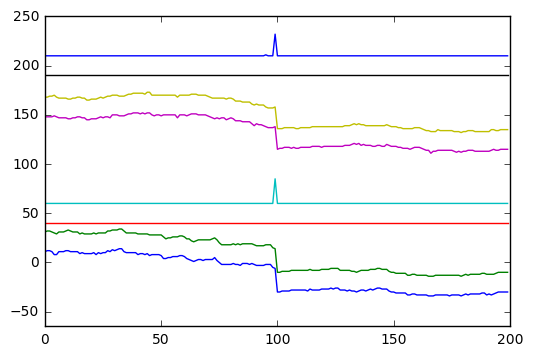

b'germline'


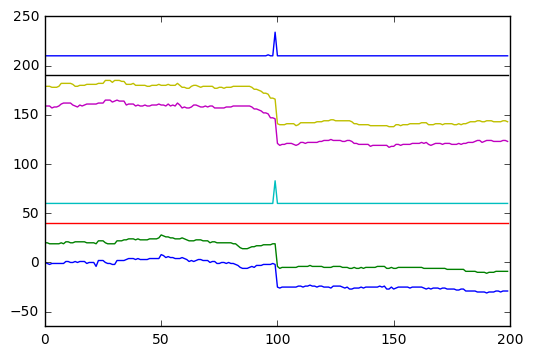

b'germline'


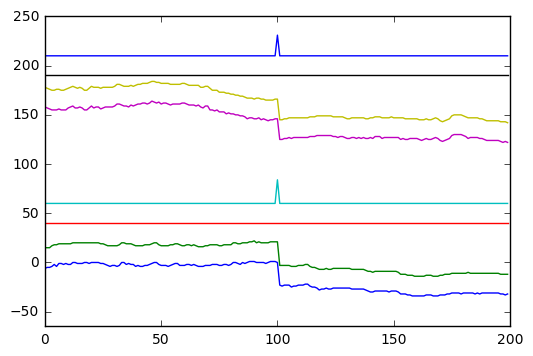

b'germline'


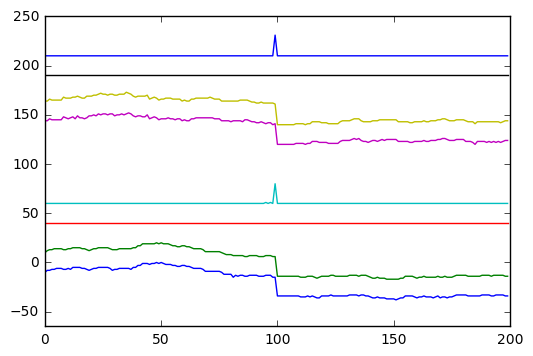

b'germline'


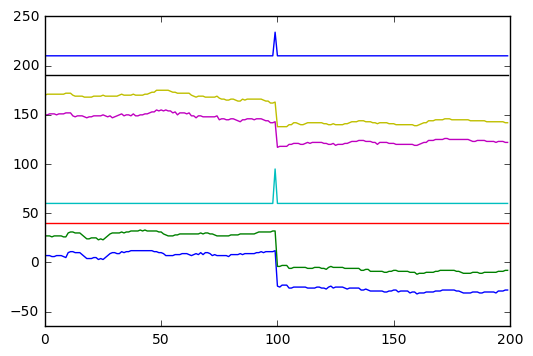

b'germline'


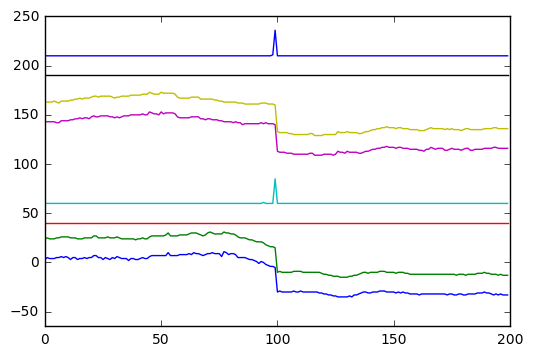

b'germline'


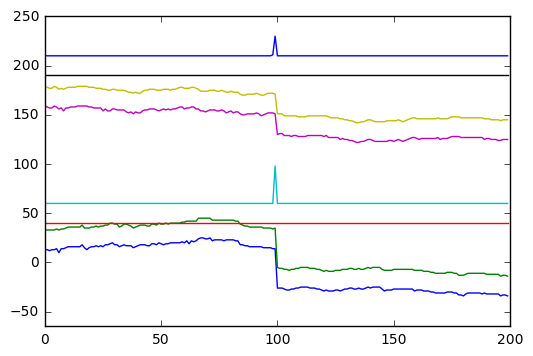

b'germline'


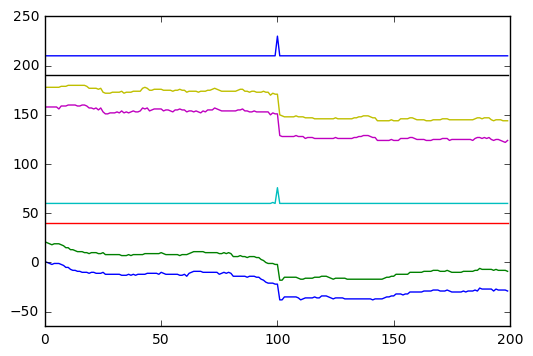

b'germline'


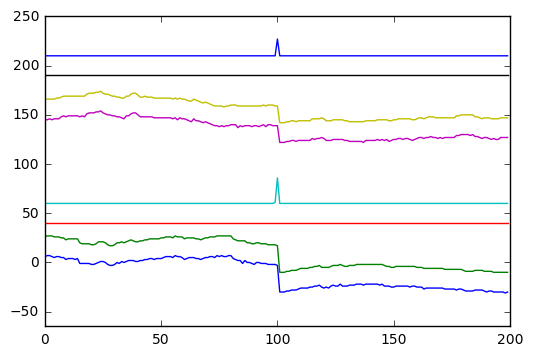

b'germline'


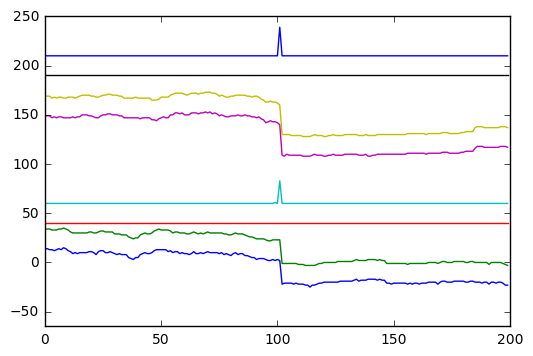

In [163]:
start_window = 100
plot_channels(start_window, n_windows)

## Plots several windows from the somatic SV category

b'somatic'


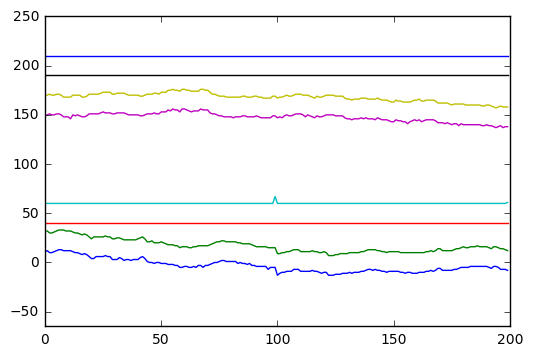

b'somatic'


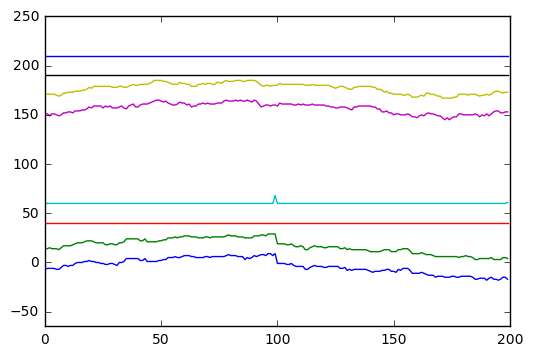

b'somatic'


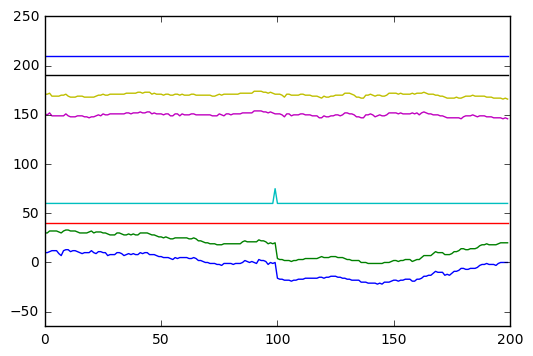

b'somatic'


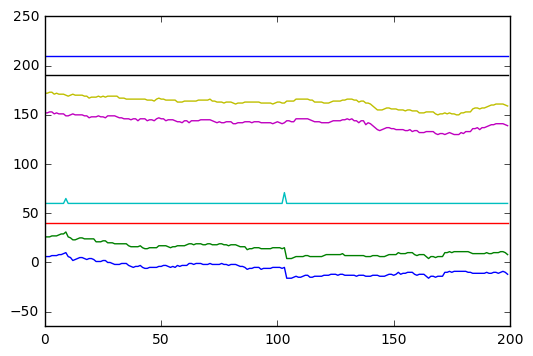

b'somatic'


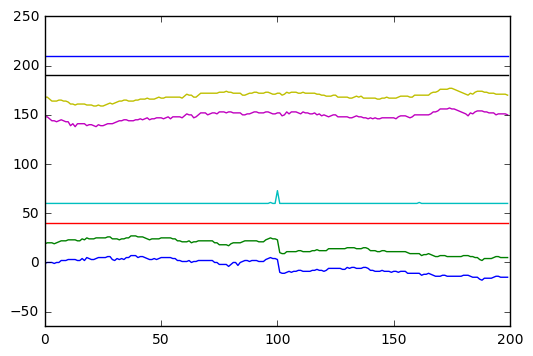

b'somatic'


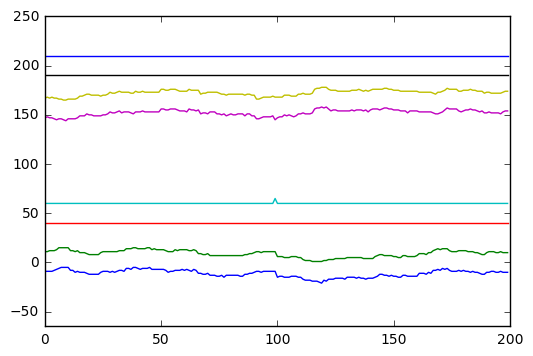

b'somatic'


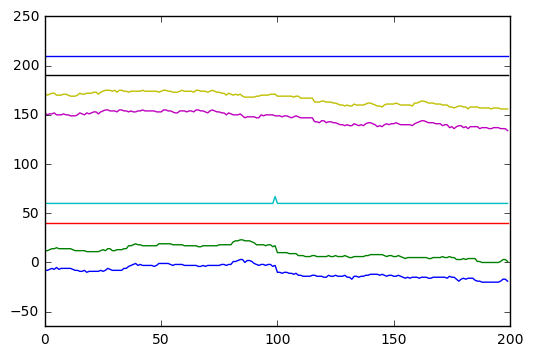

b'somatic'


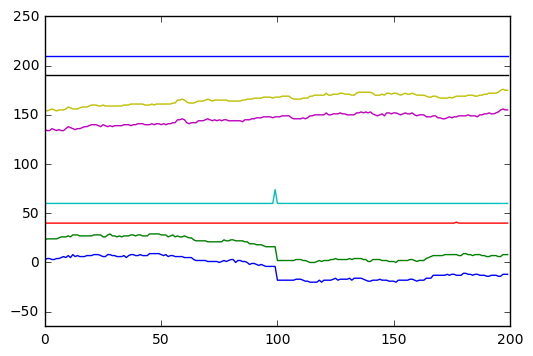

b'somatic'


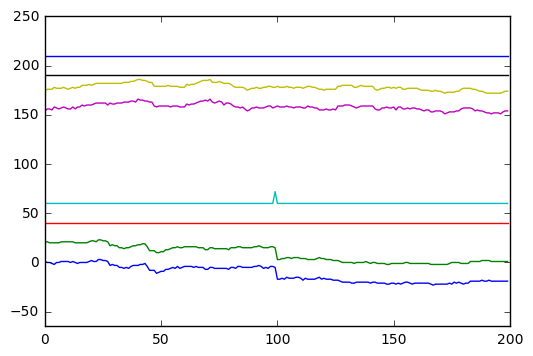

b'somatic'


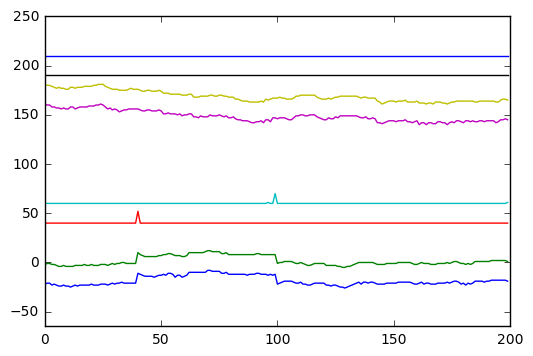

In [164]:

start_window = 7000

plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [126]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

8


## Prepare the labels in McFly format

In [127]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

{b'germline': 0, b'somatic': 1}


In [ ]:
y_test_binary

In [ ]:
y_val_binary

In [128]:
X_train.shape

(12000, 200, 8)

## Generate neural networks architectures

In [80]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [81]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [ ]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 2,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=4,
                                  cnn_min_fc_nodes=5, 
                                  cnn_max_fc_nodes=15,
                                  low_lr=4, high_lr=8)

In [29]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'learning_rate': 4.34533240505395e-07, 'filters': array([13, 19, 88]), 'regularization_rate': 0.00015697050209298365, 'fc_hidden_nodes': 14}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_11 (BatchNormali(None, 200, 8)      16          batchnormalization_input_3[0][0] 
____________________________________________________________________________________________________
convolution1d_7 (Convolution1D)    (None, 200, 13)     325         batchnormalization_11[0][0]      
____________________________________________________________________________________________________
batchnormalization_12 (BatchNormali(None, 200, 13)     26          convolution1d_7[0][0]            
____________________________________________________________________________________________________
activation_11 (Activation)         (None, 200, 13)

## Train the networks

In [115]:
train_set_size = X_train.shape[0]
train_set_size

12000

In [82]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5, 
                                                                                  subset_size=train_set_size,
                                                                                  verbose=True)

Training model 0 CNN
Train on 12000 samples, validate on 3600 samples
Epoch 1/5
12000/12000 [==============================] - 174s - loss: 0.2063 - acc: 0.9847 - val_loss: 0.1736 - val_acc: 0.9814
Epoch 2/5
12000/12000 [==============================] - 152s - loss: 0.2032 - acc: 0.9847 - val_loss: 0.1627 - val_acc: 0.9856
Epoch 3/5
12000/12000 [==============================] - 163s - loss: 0.1990 - acc: 0.9860 - val_loss: 0.1576 - val_acc: 0.9844
Epoch 4/5
12000/12000 [==============================] - 188s - loss: 0.1984 - acc: 0.9871 - val_loss: 0.1483 - val_acc: 0.9892
Epoch 5/5
12000/12000 [==============================] - 191s - loss: 0.1917 - acc: 0.9887 - val_loss: 0.1541 - val_acc: 0.9889
Training model 1 CNN
Train on 12000 samples, validate on 3600 samples
Epoch 1/5
12000/12000 [==============================] - 74s - loss: 0.1698 - acc: 0.9950 - val_loss: 0.1248 - val_acc: 0.9903
Epoch 2/5
12000/12000 [==============================] - 74s - loss: 0.1674 - acc: 0.9942 - v

## Plot training process

Currently run with a very low number of epochs

CPU times: user 1.92 s, sys: 12 ms, total: 1.94 s
Wall time: 2.01 s


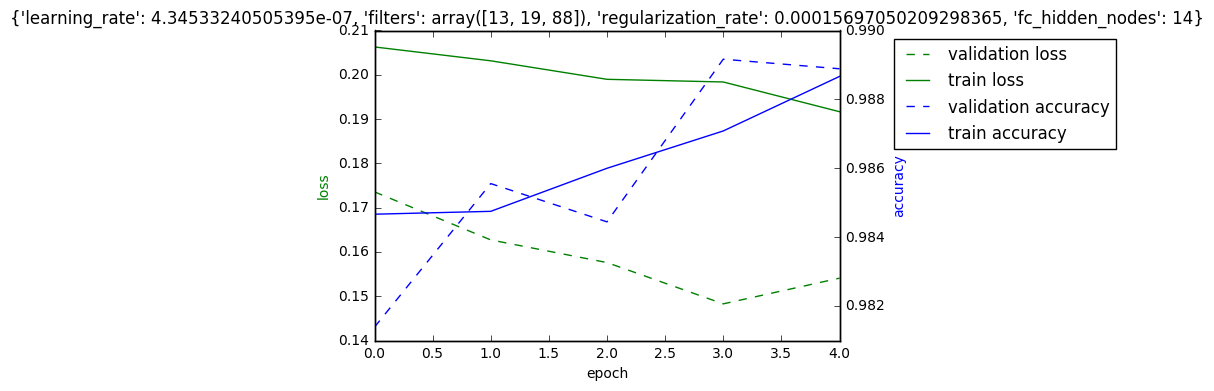

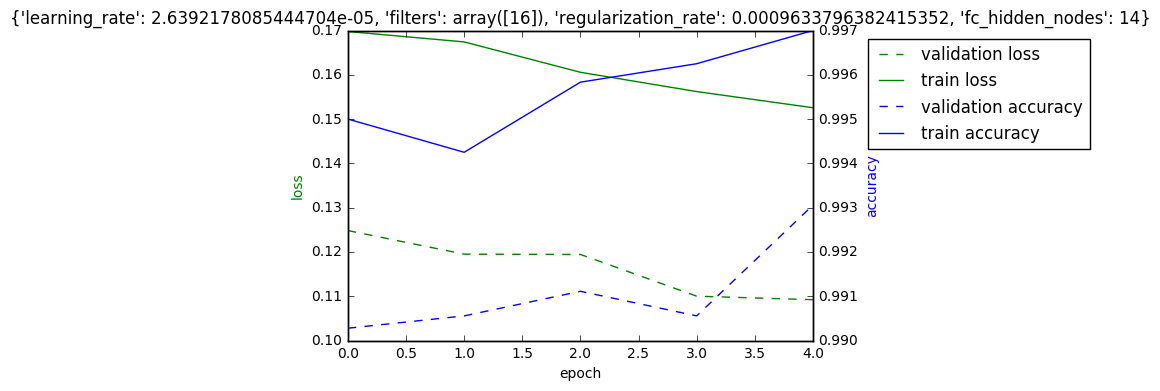

In [83]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [84]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'learning_rate': 4.34533240505395e-07, 'filte...",0.988667,0.191665,0.988889,0.154075
1,"{'learning_rate': 2.6392178085444704e-05, 'fil...",0.997000,0.152563,0.993056,0.109212


## Take the best current model 

In [120]:
best_model_index = 1
best_model_index = np.argmax(val_accuracies)

In [121]:
best_model_index

1

In [86]:
import theano
theano.config.mode

'Mode'

In [87]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 CNN {'learning_rate': 2.6392178085444704e-05, 'filters': array([16]), 'regularization_rate': 0.0009633796382415352, 'fc_hidden_nodes': 14}


In [88]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'])
best_model_copy = best_model
print(best_model_index, best_model_types, best_params)

1 CNN {'learning_rate': 2.6392178085444704e-05, 'filters': array([16]), 'regularization_rate': 0.0009633796382415352, 'fc_hidden_nodes': 14}


## Save the best current model

In [89]:
from mcfly import storage
name_best_model = 'Gtcg_1_6_12_17_99val'

In [90]:
storage.savemodel(best_model,'/home/sonja/sonja/',name_best_model )

('/home/sonja/sonja/Gtcg_1_6_12_17_99val_architecture.json',
 '/home/sonja/sonja/Gtcg_1_6_12_17_99val_weights')

## Reload the best current model

In [91]:

from mcfly import storage
model_reloaded = storage.loadmodel('/home/sonja/sonja/',name_best_model )
model_reloaded.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(best_params['learning_rate']), 
                  metrics=['accuracy']) 

## Train the best model (not used for now)

In [ ]:
nr_epochs = 3

datasize = X_train.shape[0]#1000
history = model_reloaded.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

In [ ]:
find_architecture.plotTrainingProcess(history)

## Test best current model on testset

### Overall accuracy on the test set:

In [92]:
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.10318961280291197, 0.99644808749683567]


### Re-check the train and validation scores: 

In [ ]:
best_model.get_config()[0]

In [64]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=False)
print('Train Score of best model: ' + str(score_train))

Train Score of best model: [0.11980280119180679, 0.997]


In [65]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=False)
print('Val Score of best model: ' + str(score_val))

Val Score of best model: [0.12114071402284834, 0.99277777777777776]


## Reload the best  model ever

In [124]:
from mcfly import storage

name_best_model_ever = 'Gtcg_1_5_12_17_99val'
model_reloaded = storage.loadmodel('/home/sonja/sonja/',name_best_model_ever )
model_reloaded.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(best_params['learning_rate']), 
                  metrics=['accuracy']) 

## Test best ever model on testset

### Overall accuracy on the test set:

In [129]:
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.11563290100280053, 0.99699453558426732]
